## SPECTDF Decision Tree Classifier

### Load the libraries + data

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV, learning_curve

In [45]:
# file with attribute names
with open('spectf+heart/SPECTF.names') as f:
    file = f.readlines()

In [46]:
# show the attribute names
# file[43:89]

In [47]:
# clean up the column names
col_names = [i.split(':')[0].replace(" ","").split(".")[1] for i in file[44:89]]

In [48]:
# read test and train data
train_data = pd.read_csv('spectf+heart/SPECTF.train', header=None, names=col_names)
test_data = pd.read_csv('spectf+heart/SPECTF.test', header=None, names=col_names)

In [49]:
train_data.head()

,OVERALL_DIAGNOSIS,F1R,F1S,F2R,F2S,F3R,F3S,F4R,F4S,F5R,...,F18R,F18S,F19R,F19S,F20R,F20S,F21R,F21S,F22R,F22S
0,1,59,52,70,67,73,66,72,61,58,...,66,56,62,56,72,62,74,74,64,67
1,1,72,62,69,67,78,82,74,65,69,...,65,71,63,60,69,73,67,71,56,58
2,1,71,62,70,64,67,64,79,65,70,...,73,70,66,65,64,55,61,41,51,46
3,1,69,71,70,78,61,63,67,65,59,...,61,61,66,65,72,73,68,68,59,63
4,1,70,66,61,66,61,58,69,69,72,...,67,69,70,66,70,64,60,55,49,41


In [50]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   OVERALL_DIAGNOSIS  80 non-null     int64
 1   F1R                80 non-null     int64
 2   F1S                80 non-null     int64
 3   F2R                80 non-null     int64
 4   F2S                80 non-null     int64
 5   F3R                80 non-null     int64
 6   F3S                80 non-null     int64
 7   F4R                80 non-null     int64
 8   F4S                80 non-null     int64
 9   F5R                80 non-null     int64
 10  F5S                80 non-null     int64
 11  F6R                80 non-null     int64
 12  F6S                80 non-null     int64
 13  F7R                80 non-null     int64
 14  F7S                80 non-null     int64
 15  F8R                80 non-null     int64
 16  F8S                80 non-null     int64
 17  F9R               

In [51]:
# look for null values
train_data.isna().sum()

OVERALL_DIAGNOSIS    0
F1R                  0
F1S                  0
F2R                  0
F2S                  0
F3R                  0
F3S                  0
F4R                  0
F4S                  0
F5R                  0
F5S                  0
F6R                  0
F6S                  0
F7R                  0
F7S                  0
F8R                  0
F8S                  0
F9R                  0
F9S                  0
F10R                 0
F10S                 0
F11R                 0
F11S                 0
F12R                 0
F12S                 0
F13R                 0
F13S                 0
F14R                 0
F14S                 0
F15R                 0
F15S                 0
F16R                 0
F16S                 0
F17R                 0
F17S                 0
F18R                 0
F18S                 0
F19R                 0
F19S                 0
F20R                 0
F20S                 0
F21R                 0
F21S                 0
F22R       

No null values

In [60]:
# descriptive statistics
train_data.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
OVERALL_DIAGNOSIS,80.0,0.50,0.503155,0.0,0.00,0.5,1.00,1.0
F1R,80.0,68.65,5.594075,57.0,64.75,69.0,72.00,80.0
F1S,80.0,67.55,6.884030,51.0,64.00,67.0,73.00,81.0
F2R,80.0,69.55,5.901941,52.0,66.00,70.0,74.00,82.0
F2S,80.0,70.85,6.326757,51.0,67.00,72.0,75.25,84.0


### Comparing decision trees

**Instruction**<br>
Task: Create a function that outputs a good estimate of the classifier’s performance, averaged over 100 trials of 10-fold cross-validation over the SPECTF data set.
Make certain to observe the following details:
* For each trial, split the data randomly into 10 folds, choose one to be the “test” fold and train the decision tree classifier on the remaining nine folds. Then, evaluate the trained model on the held-out “test” fold to obtain its performance.
* Repeat this process until each fold has been the test fold exactly once, then advance to the next trial.
* Be certain to shuffle the data at the start of each trial, but never within a trial. Report the mean and standard deviation of the prediction accuracy over all 100 trials of 10-fold cross validation. In the end, you should be computing statistics for 1,000 accuracy values.

**Note:** although scikit-learn provides libraries that implement cross-fold validation, you may not use them for this assignment – you must implement cross-fold validation yourself.
Once it is working for the basic decision tree, modify this script to also evaluate the performance of decision stumps (a 1-level decision tree) and a 3-level decision tree on the same data. <br>
You may again use the built-in scikit-learn decision tree classifier. Make certain that the three classifiers are trained and tested on exactly the same subsets of the data each trial/fold. Your implementation should be placed entirely in the evaluatePerformance() function, which should output a matrix of statistics as defined in the API specified in the function header in dtree eval.py. Once you are done, please comment out unnecessary print statements (e.g., ones you used for debugging). This will further accelerate your implementation.

In [61]:
def evaluate_performance(train_data: pd.DataFrame = train_data, max_depth: int =1) -> tuple[float, float]:
    '''
    Evaluate the performance of a decision tree model using 10-fold cross-validation.

    Parameters:
    ----------
    train_data : pd.DataFrame
    max_depth : int
         intended depth for the decision tree model(default = 1)
    
    
    Returns:
    -------
    tuple[float, float]
        A tuple containing:
        - mean_accuracy: The overall mean accuracy across all trials and folds.
        - std_accuracy: The standard deviation of accuracy across all trials and folds.     
    '''
    all_test_accuracies = []
    for trial in range(100):
        randomized_data = shuffle(train_data, random_state=trial)
        batch_size = train_data.shape[0] // 10
        trial_accuracies = []
        
        # 10-fold cross-validation 
        for i in range(10):
            test_split = randomized_data.iloc[i * batch_size:(i + 1) * batch_size]
            train_split = randomized_data.drop(test_split.index)
            
            # Separate features and labels
            test_split_X = test_split.drop('OVERALL_DIAGNOSIS', axis=1)
            test_split_y = test_split['OVERALL_DIAGNOSIS']
            train_split_X = train_split.drop('OVERALL_DIAGNOSIS', axis=1)
            train_split_y = train_split['OVERALL_DIAGNOSIS']
            
            # Train 
            clf = DecisionTreeClassifier(max_depth=max_depth)
            clf.fit(train_split_X, train_split_y)
            
            # Test
            test_accuracy = clf.score(test_split_X, test_split_y)
            trial_accuracies.append(test_accuracy)
            
        
        all_test_accuracies.extend(trial_accuracies)

    # Overall mean and standard deviation
    mean_accuracy = np.mean(all_test_accuracies)
    std_accuracy = np.std(all_test_accuracies)

    print(f"Mean accuracy over 100 trials of 10-fold CV: {mean_accuracy:.4f}")
    print(f"Standard deviation of accuracy: {std_accuracy:.4f}")
    
    return mean_accuracy, std_accuracy

In [62]:
evaluate_performance(max_depth=1)

Mean accuracy over 100 trials of 10-fold CV: 0.6835
Standard deviation of accuracy: 0.1561


(0.6835, 0.1560737005392004)

In [57]:
evaluate_performance(max_depth=3)

Mean accuracy over 100 trials of 10-fold CV: 0.6514
Standard deviation of accuracy: 0.1444


(0.651375, 0.1443995650097326)

#### Explanation<br>
1. **Depth 1 (Decision Stump):**

* Mean accuracy: 0.6835<br>
* Standard deviation: 0.1561<br>
This indicates that a simple decision stump (a 1-level tree) achieved a relatively higher average accuracy but also had a higher standard deviation, suggesting more variability in performance across different folds and trials.<br>

2. **Depth 3:**<br>

* Mean accuracy: 0.6514<br>
* Standard deviation: 0.1444<br>
Here, the mean accuracy is slightly lower than for the depth-1 tree, and the standard deviation is somewhat reduced. This could indicate that a 3-level tree has less variability but may not capture patterns as effectively in this dataset, potentially due to overfitting on smaller subsets during cross-validation.

### Generating a Learning Curve

**Instruction**<br>
Modify the code above to also generate and output a plot showing the learning curve over the training data. <br>
The learning curve should plot the mean and standard deviation of the test accuracy for 10%, 20%, . . . , 100% of the training data. Note that 100% of the training data corresponds to only 90% of the complete data set, since we’re doing 10-fold cross-validation.
As before, the learning curve statistics should be computed over 100 trials of 10-fold cross-validation. Make certain that you compute the learning curve for each subset of the training set for a particular trial/fold combination; in other words, the learning curve should be generated in an inner loop inside the trial/fold loops. In addition to the decision stumps, 3-level decision tree, and depth-unlimited decision tree, add a few additional decision trees of varying limited depths to explore the effect of decision tree depth on learning performance. Display the learning curves for all classifiers on the same plot. Add a well-labeled key to your plot.
To display the standard deviations on the plot, see the fill between http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.fill_between) or errorbar (http://matplotlib.org/examples/statistics/errorbar_demo_features.html) functions in matplotlib.

In [58]:
def evaluate_dt_performance(train_data: pd.DataFrame, depths: list = [1, 3, None]) -> tuple[float, float]:
    '''
    Evaluates the performance of decision tree classifiers of varying depths on the input training data
    using 100 trials of 10-fold cross-validation. Additionally, generates and plots learning curves for each
    specified tree depth, showing test accuracy as the training size increases.
    
    Parameters:
    ----------
    train_data : pd.DataFrame
    depths : list, optional
        List of maximum depths for decision tree classifiers to be evaluated. Defaults to [1, 3, None],
        where None represents an unlimited depth decision tree.

    Returns:
    -------
    tuple[float, float]
        A tuple containing:
        - mean_accuracy: The overall mean accuracy across all trials and folds.
        - std_accuracy: The standard deviation of accuracy across all trials and folds.    
    '''
    # Dictionary to hold accuracies for different depths
    learning_curves = {depth: [] for depth in depths}
    
    all_test_accuracies = []

    # 100 trials of 10-fold cross-validation
    for trial in range(100):
        randomized_data = shuffle(train_data, random_state=trial)
        batch_size = train_data.shape[0] // 10
        trial_accuracies = []

        # 10-fold cross-validation
        for i in range(10):
            test_split = randomized_data.iloc[i * batch_size:(i + 1) * batch_size]
            train_split = randomized_data.drop(test_split.index)

            # Separate features and labels
            test_split_X = test_split.drop('OVERALL_DIAGNOSIS', axis=1)
            test_split_y = test_split['OVERALL_DIAGNOSIS']
            train_split_X = train_split.drop('OVERALL_DIAGNOSIS', axis=1)
            train_split_y = train_split['OVERALL_DIAGNOSIS']

            # Learning curve data for different training sizes
            training_sizes = [int(len(train_split_X) * (i + 1) / 10) for i in range(10)]
            
            for depth in depths:
                depth_accuracies = []
                for size in training_sizes:
                    X_subset = train_split_X.iloc[:size]
                    y_subset = train_split_y.iloc[:size]

                    clf = DecisionTreeClassifier(max_depth=depth)
                    clf.fit(X_subset, y_subset)

                    test_accuracy = clf.score(test_split_X, test_split_y)
                    depth_accuracies.append(test_accuracy)

                learning_curves[depth].append(depth_accuracies)
        
        all_test_accuracies.extend(trial_accuracies)

    # Overall mean and standard deviation for test accuracies
    mean_accuracy = np.mean(np.array(all_test_accuracies))
    std_accuracy = np.std(all_test_accuracies)

    # Convert learning curves to numpy arrays for easier processing
    for depth in depths:
        learning_curves[depth] = np.array(learning_curves[depth])

    # Plotting the learning curves
    plt.figure(figsize=(10, 6))
    for depth in depths:
        mean_scores = learning_curves[depth].mean(axis=0)
        std_scores = learning_curves[depth].std(axis=0)

        # Plot with fill between to show standard deviation
        plt.plot(training_sizes, mean_scores, label=f'Depth {depth}' if depth is not None else 'Depth Unlimited')
        plt.fill_between(training_sizes, mean_scores - std_scores, mean_scores + std_scores, alpha=0.1)

    plt.title("Learning Curves for Decision Tree Classifiers")
    plt.xlabel("Training Set Size")
    plt.ylabel("Test Accuracy")
    plt.xticks(training_sizes)
    plt.grid()
    plt.legend()
    plt.show()

    return mean_accuracy, std_accuracy

c:\Users\swift\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\swift\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\swift\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\swift\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\swift\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.

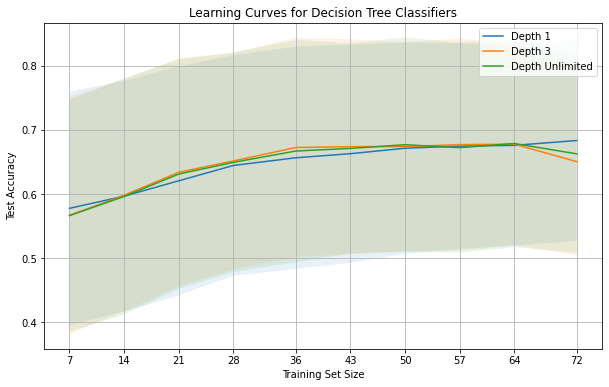

nan nan


In [78]:
mean_accuracy, std_accuracy = evaluate_dt_performance(train_data);

#### Explanation
The plot shows learning curves for decision tree classifiers with different depths (1, 3, and unlimited). Each line represents the mean test accuracy for models trained with varying portions of the training data, from 10% up to 100%(90%), with shaded regions indicating the standard deviation. <br><br>
**Observations**:

1. Accuracy Increase with Training Size: Test accuracy improves as the training set size increases for all depths, though the improvement diminishes as it reaches the upper portion of the training data.

2. Effect of Depth on Accuracy: The unlimited-depth tree appears to yield a slightly better test accuracy throughout compared to the restricted depths (1 and 3), but is eventually overtaken by the depth 1 tree. This could be because the lower depth tree does not overfit, especially because the size of the dataset is very small.

3. Variance across Depths: The shaded regions show higher variance in accuracy, especially for the depth = 3, and unlimited depth model, which suggests that they may be more sensitive to data variations and potentially prone to overfitting.

4. Convergence of Accuracy: All models show similar accuracy levels as training data increases, indicating that further increasing depth may not yield substantial accuracy gains for this dataset.


### Cross eval with scikit learn

In [63]:
X = train_data.drop('OVERALL_DIAGNOSIS', axis=1)
y = train_data['OVERALL_DIAGNOSIS']
X_test = test_data.drop('OVERALL_DIAGNOSIS', axis=1)
y_test = test_data['OVERALL_DIAGNOSIS']

In [64]:
dt = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, random_state=1 )
dt.fit(X, y)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, random_state=1)

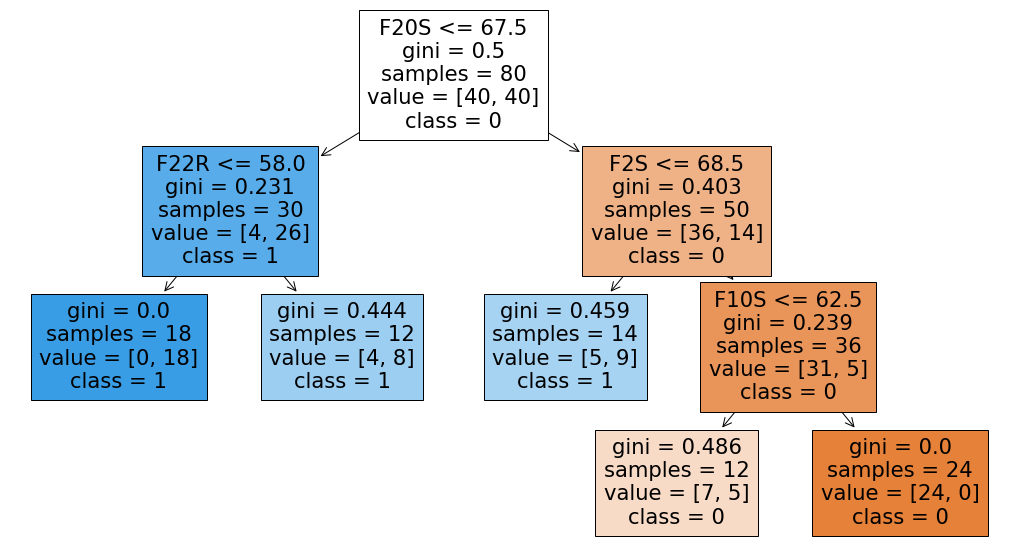

In [65]:
plt.figure(figsize=(18,10))
plot_tree(dt, feature_names = X.columns, class_names=['0', '1'], filled=True)
plt.show()

In [66]:
y_pred_train = dt.predict(X)
y_pred = dt.predict(X_test)
y_prob = dt.predict_proba(X_test)

print('Accuracy of Decision Tree-Train: ', accuracy_score(y_pred_train, y))
print('Accuracy of Decision Tree-Test: ', accuracy_score(y_pred, y_test))

Accuracy of Decision Tree-Train:  0.825
Accuracy of Decision Tree-Test:  0.7379679144385026


In [79]:
param_grid = {
    'max_depth': [1, 3, 5, 7, 10, 13],
    'min_samples_leaf': [1, 5, 10, 20, 29]
}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=10, scoring='accuracy')
grid_search.fit(X, y)
best_dt = grid_search.best_estimator_
best_dt

DecisionTreeClassifier(max_depth=1, min_samples_leaf=29, random_state=1)

In [80]:
best_dt.fit(X, y)

y_pred_train = best_dt.predict(X)
y_pred = best_dt.predict(X_test)
y_prob = best_dt.predict_proba(X_test)

In [81]:
print('Accuracy of Decision Tree-Train: ', accuracy_score(y_pred_train, y))
print('Accuracy of Decision Tree-Test: ', accuracy_score(y_pred, y_test))

Accuracy of Decision Tree-Train:  0.775
Accuracy of Decision Tree-Test:  0.6256684491978609


In [82]:
print('Classification Report:\n', classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.14      0.73      0.24        15
           1       0.96      0.62      0.75       172

    accuracy                           0.63       187
   macro avg       0.55      0.67      0.50       187
weighted avg       0.90      0.63      0.71       187



In [83]:
def plot_learning_curve(estimator, X, y, cv=5, scoring='accuracy'):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )
    
    # Calculate mean and standard deviation for training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    
    # Plot learning curves
    plt.figure()
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel(scoring.capitalize())
    plt.grid()

    # Plot the training scores
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    
    # Plot the validation scores
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()


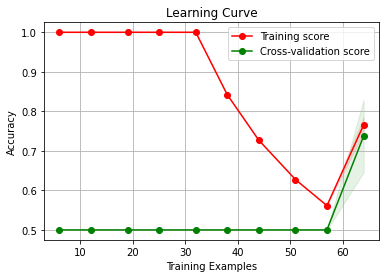

In [84]:
plot_learning_curve(best_dt, X, y, cv=5, scoring='accuracy')

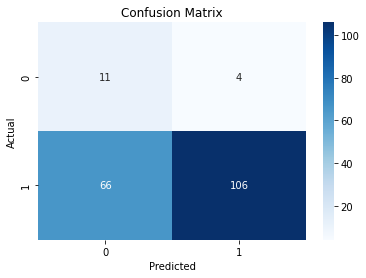

In [85]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

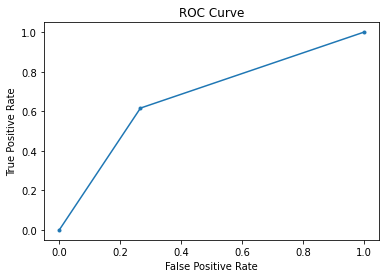

In [86]:
fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

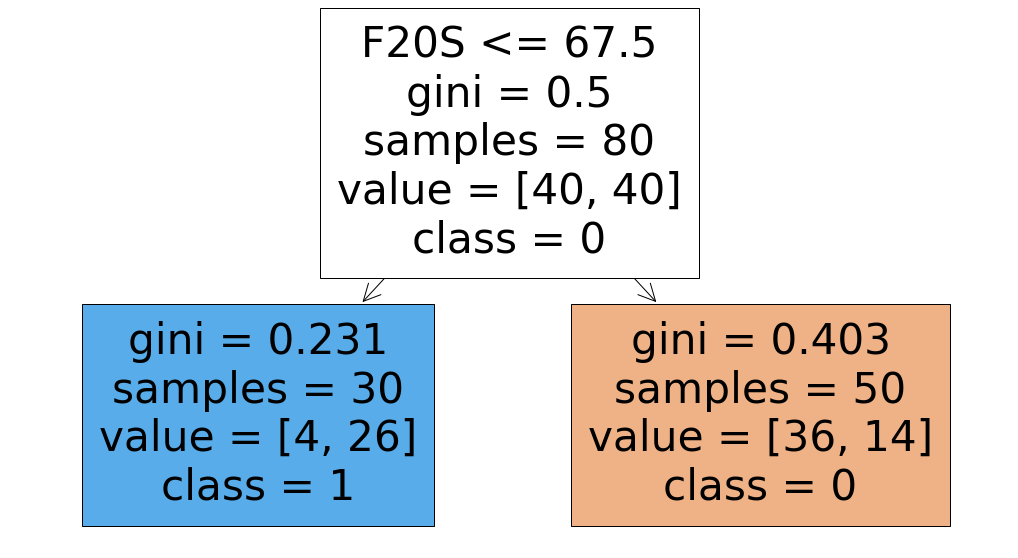

In [87]:
plt.figure(figsize=(18,10))
plot_tree(best_dt, feature_names=X.columns, class_names=['0', '1'], filled=True)
plt.show()